# Bot 

In [ ]:

import logging
from telegram import Update, Bot
from telegram.ext import Updater, CommandHandler, MessageHandler, Filters, CallbackContext

bot = Bot(token=API_TOKEN)
updater = Updater(token=API_TOKEN, use_context=True)
dispatcher = updater.dispatcher

logging.basicConfig(format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
                     level=logging.INFO)


def send_new_channel_messages(update: Update, context: CallbackContext):
    channel_id = 'my life'
    channel_updates = bot.get_chat_updates(channel_id)

    user_id = update.message.from_user.id

    for update in channel_updates:
        if update.message:
            bot.forward_message(chat_id=user_id, from_chat_id=channel_id, message_id=update.message.message_id)


def start(update: Update, context: CallbackContext):
    user_id = update.message.from_user.id
    update.message.reply_text(f"Hello! I will send you new messages from the channel.")


def main():
    dispatcher.add_handler(MessageHandler(Filters.chat_type.channel, send_new_channel_messages))
    dispatcher.add_handler(CommandHandler("start", start))

    updater.start_polling()
    updater.idle()


if __name__ == '__main__':
    main()

# Config upload

In [1]:
import configparser
import json

from telethon import TelegramClient
from telethon.errors import SessionPasswordNeededError

In [2]:
# Reading Configs
config = configparser.ConfigParser()
config.read("config.ini")

# Setting configuration values
api_id = config['Telegram']['api_id']
api_hash = config['Telegram']['api_hash']
api_token = config['Telegram']['api_token']

api_hash = str(api_hash)

phone = config['Telegram']['phone']
username = config['Telegram']['username']
channel_link = config['Telegram']['channel_link'] 

db_name = config['database']['db_name']
db_user = config['database']['db_user']
db_password = config['database']['db_password'] 
db_host = config['database']['db_host'] 


In [3]:
from transformers import pipeline


#facebook_bart_large_mnli = pipeline("zero-shot-classification", model="/media/tonyalpha/HDD/facebook-bart-large-mnli")
#bertweet_base_sentiment_analysis = pipeline("text-classification", model="/media/tonyalpha/HDD/bertweet-base-sentiment-analysis")

In [32]:
# if not client.is_user_authorized():
#     client.send_code_request(phone)
#     try:
#         client.sign_in(phone, input('Enter the code: '))
#     except SessionPasswordNeededError:
#         client.sign_in(password=input('Password: '))

# me = client.get_me()
# print(me)

# Get data from telegram 

In [4]:
from telethon.tl.types import InputMessagesFilterPhotos
from telethon import TelegramClient, events
import nest_asyncio

nest_asyncio.apply()

import os.path

def get_posts(num_posts = 1, download_media = False, only_with_media = True, offset_id = 0, posts_list = []):
    client = TelegramClient(username, api_id, api_hash)
    posts_list = []
    async def main(num_posts, download_media, offset_id, posts_list):
        
        if num_posts < 100:
            message_limit = num_posts
        else:
            message_limit = 100
            
            
        last_post_date = None
        post = {}
        
        await client.start()

        try:
            entity = await client.get_entity(channel_link)

            while True:
                messages = await client.get_messages(entity, limit=message_limit, offset_id = offset_id)

                for message in messages:
                    
                    if only_with_media:
                        if not message.media:
                            continue
                    
                    if last_post_date == None:
                        last_post_date = message.date

                    # if delay between uploading messages is more than 10 second i will separate them
                    if (last_post_date - message.date).seconds > 10: 
                        post['upload_date'] = last_post_date.strftime('%Y-%m-%d %H:%M:%S') if last_post_date else None

                        last_post_date = message.date

                        posts_list.append(post)
                        post = {}


                    if len(message.message) > 0:
                        post['text'] = post.get('text', '') + message.message 
                        
                        # post_id in messages set will be id of message with text and photo 
                        post['post_id'] = message.id


                    if message.media and download_media:

                        photo_id = message.media.photo.id
                        filename = f'image_{photo_id}.jpg'
                        path = f"./media/{filename}"

                        # some of this i should drop, but later 
                        post['photos_id_list'] = post.get('photos_id_list', []) + [photo_id]
                        post['photos_names_list'] = post.get('photos_names_list', []) + [filename]

                        #if file exist check 
                        if not os.path.isfile(path) and download_media:
                            await client.download_media(message, file=path)

                    post['id_list'] = post.get('id_list', []) + [message.id]
                    post['edit_date'] = message.edit_date.strftime('%Y-%m-%d %H:%M:%S') if message.edit_date else None


                offset_id = messages[len(messages) - 1].id

                if len(posts_list) >= num_posts:
                    break


        except Exception as e:
            print(f"Error: {e}")

        await client.disconnect()
        
        return posts_list

    if __name__ == "__main__":
        client.loop.run_until_complete(main(num_posts, download_media, offset_id, posts_list))
        
    return posts_list

# Data parsing

In [5]:
import re 

def parse_text(dct):
    
    input_string = dct.get('text', None)
    
    if input_string is None:
        return dct
    
    date_pattern = r'\d{2}\.\d{2}\.\d{2}'
    day_pattern = r'\b(?:MONDAY|TUESDAY|WEDNESDAY|THURSDAY|FRIDAY|SATURDAY|SUNDAY)\b'
    
    date_match = re.search(date_pattern, input_string)
    day_match = re.search(day_pattern, input_string)
    
    date = date_match.group() if date_match else None
    day = day_match.group() if day_match else None
    
    parsed_date = date.split('.')[-1] + '-' + date.split('.')[1] + '-' + date.split('.')[0] if date or day else None
    
    dct['parsed_date'] = parsed_date
    
    if date_match:
        input_string = input_string.replace(date_match.group(), "") if parsed_date is not None else input_string
    if day_match:
        input_string = input_string.replace(day_match.group(), "") if parsed_date is not None else input_string
    
    regex_list = [r'How productive have you been\?:\s*(\S|\s+|\d+\.?\d*)/10', r'How interesting was the day\?:\s*(\S|\s+|\d+\.?\d*)/10', r'How stressful was the day\?:\s*(\S|\s+|\d+\.?\d*)/10']
    names_list = ['productivity_score', 'interest_score', 'stress_score']
    
    for regex, name in zip(regex_list, names_list):
        match = re.search(regex, input_string)
        
        if match:
            try:
                parsed_score = float(match.group(1))
            except:
                parsed_score = None
        else:
            parsed_score = None
        
        
        #parsed_score = match.group(1) if match and match.group(1).isdigit() else None
        
        dct[name] = parsed_score

        input_string = input_string.replace(match.group(), "") if match else input_string
        
    
    dct['parsed_text'] = input_string.split('\n')
    return dct
    
def parse_activities(dct):
    
    input_list = dct.get('parsed_text', None)
    
    if input_list is None:
        return dct
    
    result = []
    for item in input_list:
        match = re.match(r'^([\U0001F000-\U0001F9FF]+|[\U0001FA00-\U0001FA6F]+|\*)?\s*(.*)$', item)
        if match:
            emoji = match.group(1)
            text = match.group(2).strip()
            if emoji or text:
                result.append((emoji, text))
                
    dct['parsed_activities'] = result
    return dct

In [103]:
get_posts(num_posts = 1)

[{'id_list': [724, 723, 722, 721],
  'edit_date': '2023-07-28 12:50:10',
  'text': '26.07.23\n\nsakisaki Hiking with Ann\n\nWorking on my project\n\n* Gym \n\n* Interesting history lecture \n\nHow productive have you been?: 4.5/10\nHow interesting was the day?: 6/10\nHow stressful was the day?: 1/10',
  'post_id': 721,
  'upload_date': '2023-07-26 16:28:42'}]

In [104]:
parse_text(get_posts(num_posts = 4)[2])

{'id_list': [717, 716, 715],
 'edit_date': '2023-07-26 16:02:48',
 'text': '24.07.23\n\nGym: good traning \n\nMy project for portfolio: do some things  \n\nInteresting history lecture  \n\nHow productive have you been?: 4.5/10\nHow interesting was the day?: 5/10\nHow stressful was the day?: 0/10',
 'post_id': 715,
 'upload_date': '2023-07-26 13:31:56',
 'parsed_date': '23-07-24',
 'productivity_score': 4.5,
 'interest_score': 5.0,
 'stress_score': 0.0,
 'parsed_text': ['',
  '',
  'Gym: good traning ',
  '',
  'My project for portfolio: do some things  ',
  '',
  'Interesting history lecture  ',
  '',
  '',
  '',
  '']}

In [105]:
parse_activities(parse_text(get_posts(num_posts = 3)[0]))

{'id_list': [724, 723, 722, 721],
 'edit_date': '2023-07-28 12:50:10',
 'text': '26.07.23\n\nsakisaki Hiking with Ann\n\nWorking on my project\n\n* Gym \n\n* Interesting history lecture \n\nHow productive have you been?: 4.5/10\nHow interesting was the day?: 6/10\nHow stressful was the day?: 1/10',
 'post_id': 721,
 'upload_date': '2023-07-26 16:28:42',
 'parsed_date': '23-07-26',
 'productivity_score': 4.5,
 'interest_score': 6.0,
 'stress_score': 1.0,
 'parsed_text': ['',
  '',
  'sakisaki Hiking with Ann',
  '',
  'Working on my project',
  '',
  '* Gym ',
  '',
  '* Interesting history lecture ',
  '',
  '',
  '',
  ''],
 'parsed_activities': [(None, 'sakisaki Hiking with Ann'),
  (None, 'Working on my project'),
  ('*', 'Gym'),
  ('*', 'Interesting history lecture')]}

# Upload to DB 

In [6]:
        
def update_post(post_id, update_data):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            update_post_table_query= ''
            update_values = []
            
            for key, value in update_data.items():
                    update_post_table_query += key + ' = %s, '
                    update_values += [value]
            
            update_post_table_query = update_post_table_query.rstrip(', ')
            update_post_table_query = 'UPDATE posts SET ' + update_post_table_query + ' WHERE post_id = %s;'
            
            update_values += [post_id]
            update_values = tuple(update_values)
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_post_table_query, update_values)
                connection.commit()
                
            print(f'UPDATED: post with id:{post_id}')
    except Error as e:
        print(e)

        
                
def update_activity(activity_id, update_data):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            update_activity_table_query= ''
            update_values = []
            
            for key, value in update_data.items():
                    update_activity_table_query += key + ' = %s, '
                    update_values += [value]
            
            update_activity_table_query = update_activity_table_query.rstrip(', ')
            update_activity_table_query = 'UPDATE activities SET ' + update_activity_table_query + ' WHERE activity_id = %s;'
            
            update_values += [activity_id]
            update_values = tuple(update_values)
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_activity_table_query, update_values)
                connection.commit()
                
            print(f'UPDATED: activity with id:{activity_id}')
    except Error as e:
        print(e)

In [7]:
import mysql.connector

from getpass import getpass
from mysql.connector import connect, Error


def db_connect():
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            create_posts_table_query = """
            CREATE TABLE IF NOT EXISTS posts(
                post_id INT,
                text TEXT,
                parsed_date DATE,
                upload_date DATETIME,
                edit_date DATETIME, 
                productivity_score FLOAT,
                interest_score FLOAT,
                stress_score FLOAT,
                predicted_productivity_score FLOAT,
                predicted_interest_score FLOAT,
                predicted_stress_score FLOAT,
                PRIMARY KEY (post_id)
            );
            """
            
            create_posts_table_activities = """
            CREATE TABLE IF NOT EXISTS activities(
                activity_id INT AUTO_INCREMENT,
                post_id INT,
                activity_name TEXT,
                activity_emoji TEXT,
                activity_type TEXT,
                activity_emotion TEXT,
                predicted_activity_type TEXT,
                predicted_activity_emotion TEXT,
                FOREIGN KEY (post_id) REFERENCES posts(post_id),
                PRIMARY KEY (activity_id)
            );
            """
            
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(create_posts_table_query)
                cursor.execute(create_posts_table_activities)
                connection.commit()
    except Error as e:
        print(e)
        
def upload_post(dct, overwrite = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            check_if_exist = """SELECT EXISTS(SELECT 1 FROM posts WHERE post_id = %s LIMIT 1)"""
            
            upload_posts_table_query = f"""
            INSERT INTO posts (post_id, text, parsed_date, upload_date, 
            edit_date,productivity_score, interest_score, stress_score, 
            predicted_productivity_score, predicted_interest_score,
            predicted_stress_score) 
            VALUES(%s, %s, %s, %s, %s, %s, %s, %s, %s, %s, %s)
            """
            
            post_id = (dct.get('post_id', None),)
            uploaded_date = dct.get('upload_date', None)
            
            insert_data = (dct.get('post_id', None), dct.get('text', None), 
                    dct.get('parsed_date', None), dct.get('upload_date', None), 
                    dct.get('edit_date', None),dct.get('productivity_score', None),
                    dct.get('interest_score', None),dct.get('stress_score', None),
                    dct.get('predicted_productivity_score', None), dct.get('predicted_interest_score', None),
                    dct.get('predicted_stress_score', None))
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(check_if_exist, post_id)
                for el in cursor:
                    exist = el[0]
                
                if not exist:
                    cursor.execute(upload_posts_table_query, insert_data)
                    connection.commit()
                    print(f'UPLOADED: post with id:{post_id} and uploaded_date:{uploaded_date}')
                else:
                    if overwrite:
                        pass
                        print('OVERWRITED: post with id:{post_id} and uploaded_date:{uploaded_date}')
                    else:
                        print(f'ERROR: post with id:{post_id} and uploaded_date:{uploaded_date} already uploaded')
                        print('If you want to overwrite data add flag')
    except Error as e:
        print(e)
        
        
def upload_activities(dct, overwrite = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            for activity_emoji, activity_name in dct['parsed_activities']:
                
                # add or not? 
                #if activity_emoji == '*' or activity_emoji == '📦':
                #   continue
                
                activity_name = "".join(c for c in activity_name if c.isalpha() or c.isnumeric() or c == ' ' or c == '!').strip(' ')
                check_if_exist = """SELECT EXISTS(SELECT 1 FROM activities WHERE post_id = %s AND activity_name = %s LIMIT 1)"""

                upload_posts_table_query = f"""
                INSERT INTO activities (post_id, activity_name, activity_emoji, activity_type, 
                activity_emotion, predicted_activity_type, predicted_activity_emotion) 
                VALUES(%s, %s, %s, %s, %s, %s, %s)
                """
                post_id = dct.get('post_id', None)
                
                check_data = (post_id, activity_name)

                insert_data = (dct.get('post_id', None), activity_name, 
                              activity_emoji, dct.get('activity_type', None), dct.get('activity_emotion', None),
                              dct.get('predicted_activity_type', None), dct.get('predicted_activity_emotion', None))
            
                with connection.cursor() as cursor:
                    cursor.execute(use_db_query)
                    cursor.execute(check_if_exist, check_data)
                    for el in cursor:
                        exist = el[0]

                    if not exist:
                        cursor.execute(upload_posts_table_query, insert_data)
                        connection.commit()
                        print(f'UPLOADED: activity with post_id:{post_id} and activity_name:{activity_name}')
                    else:
                        # add overwrite option
                        print(f'ERROR: activity with post_id:{post_id} and activity_name:{activity_name} already uploaded')
    except Error as e:
        print(e)
        
        
def update_post(dct):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            update_posts_table_query = """
            UPDATE posts SET text = %s, parsed_date = %s,  
            upload_date = %s, edit_date = %s, productivity_score = %s,
            interest_score = %s, stress_score = %s WHERE post_id = %s
            """
            
            data = (dct.get('text', None), 
                    dct.get('parsed_date', None), dct.get('upload_date', None), 
                    dct.get('edit_date', None),dct.get('productivity_score', None),
                    dct.get('interest_score', None),dct.get('stress_score', None),
                   dct.get('post_id', None))

            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(update_posts_table_query, data)
                connection.commit()
    except Error as e:
        print(e)

def db_show_tables():
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            show_tables = "SHOW TABLES;"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(show_tables)
                for el in cursor.fetchall():
                    print(el)
    except Error as e:
        print(e)
        
def db_execute_query(query, commit = False):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(query)
                if commit:
                    connection.commit()
                for el in cursor:
                    print(el)
    except Error as e:
        print(e)

In [10]:
db_connect()

In [11]:
db_show_tables()

('activities',)
('posts',)


In [108]:
db_execute_query('SELECT activity_id FROM activities WHERE post_id = 721 AND activity_name = "Hiking with Ann" LIMIT 1')

(215,)


In [124]:
db_execute_query('DELETE FROM posts WHERE post_id > 0;', commit = True)

In [131]:
db_execute_query('DROP TABLE posts;', commit = True)

In [49]:
db_execute_query('SELECT * FROM activities WHERE post_id = 135')

In [50]:
db_execute_query('DELETE FROM posts WHERE post_id = 135', commit = True)

In [262]:
update_activity(9, {'activity_name': 'Hiking with Ann'})

UPDATED: activity with id:9


In [37]:
db_execute_query('SELECT * FROM posts')

(125, '27.01.23\n❌ Statistics HM\n✅ Tinkoff HM (first two tasks) \n✅ Send a request for mentoring programm\n\n\nHow productive have you been?: 6/10\nHow interesting was the day?: 6/10\nHow stressful was the day?: 1/10', datetime.date(2023, 1, 27), datetime.datetime(2023, 1, 27, 8, 45, 32), datetime.datetime(2023, 7, 26, 15, 44, 40), 6.0, 6.0, 1.0, None, None, None)
(126, "28.01.23\nSlept for 6 hours, in the morning i have visited  my university and then i did'n nothing, i was really tired and sleepy. I have make i little nap but it didn't help\n\n\nHow productive have you been?: 4/10\nHow interesting was the day?: 4/10\nHow stressful was the day?: 3/10", datetime.date(2023, 1, 28), datetime.datetime(2023, 1, 28, 19, 24, 38), datetime.datetime(2023, 7, 26, 15, 44, 31), 4.0, 4.0, 3.0, None, None, None)
(127, "29.01.23 \n\n✅ Statistics: seminar \n✅ TInkoff HM: smashed it! i did't suppose that it will be not that easy\n❌ Quantum physics: HM\n✅ Make plans for month and plans for week\n\nsti

In [29]:
db_execute_query('SELECT * FROM activities WHERE activity_name LIKE \'Write people about specialization\'')

(244, 422, 'Write people about specialization', None, 'social_&_friends', None, None, None)


In [ ]:
update_activity(244, {'activity_name': 'Hiking with Ann'})

In [74]:
import datetime

datetime.date(2026, 7, 23).year

2026

In [15]:
a = {'sex':2, 'me': 5} 

In [19]:
a.items()

dict_items([('sex', 2), ('me', 5)])

# Main

In [13]:
def check_post(post):
    
    date = post.get('upload_date', None)
    
    if post.get('text', None) is None:
        print(f'I dont see any text, can you add it to post uploaded at {date}?')
        return False
    
    text = post.get('text', None)
    
    if post.get('parsed_date', None) is None:
        print(f'I dont see date, can you add it to post uploaded at {date} with text:{text}?')
        return False

    if post.get('productivity_score', None) is None:
        print(f'I dont see productivity_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('interest_score', None) is None:
        print(f'I dont see interest_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('productivity_score', None) is None:
        print(f'I dont see productivity_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
        
    if post.get('stress_score', None) is None:
        print(f'I dont see stress_score, can you add it to post uploaded at {date} with text: {text}?')
        return False
    return True

def check_activities(post):
    
    date = post.get('upload_date', None)
    
    
    if post.get('parsed_activities', None) is None or len(post.get('parsed_activities', None)) < 0:
        print(f'I dont see activities, can you add some to post uploaded at {date}?')
        return False
    return True


In [162]:


posts = get_posts(num_posts = 1000)

for post in posts:
    post = parse_text(post)
    post = parse_activities(post)
    if check_post(post):
        upload_post(post, overwrite = False)
        if check_activities(post):
            upload_activities(post, overwrite = False)

In [161]:
print('fg')

fg


# Data markup

In [14]:
from IPython.display import clear_output

def markup_activities_type(activity_types):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            
            get_activities = '''SELECT * FROM activities WHERE activity_type is NULL'''    
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(get_activities)
                for el in cursor:
                    activity_id = el[0]
                    activity_name = el[2]
                    print('==============================================================================')
                    print(f'ACTIVITY NAME: {activity_name}')
                    #print('What type of activity this is?')
                    print('\n'.join([str(i) + ' - ' + activity_types[i-1] for i in range(1, len(activity_types) + 1)]))
                    type_num = input('SELECT ACTIVITY TYPE:')
                    
                    try:
                        activity_type = activity_types[int(type_num) - 1]
                        update_activity(activity_id, {'activity_type':activity_type})
                        clear_output(wait=False)
                    except Error as e:
                        print(f'ERROR: {e}')

    except Error as e:
        print(e)
        
        
def markup_activities_sentiment(activity_emotions):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            get_activities = '''SELECT * FROM activities WHERE activity_emotion is NULL'''    
            
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                cursor.execute(get_activities)
                for el in cursor:
                    activity_id = el[0]
                    activity_name = el[2]
                    print('==============================================================================')
                    print(f'ACTIVITY NAME: {activity_name}')
                    #print('What type of activity this is?')
                    print('\n'.join([str(i) + ' - ' + activity_emotions[i-1] for i in range(1, len(activity_emotions) + 1)]))
                    emotion_num = input('SELECT ACTIVITY SENTIMENT:')
                    
                    try:
                        activity_emotion = activity_emotions[int(emotion_num) - 1]
                        update_activity(activity_id, {'activity_emotion':activity_emotion})
                        clear_output(wait=False)
                    except Error as e:
                        print(f'ERROR: {e}')

    except Error as e:
        print(e)

In [226]:
activity_types = ['self_development', 'university', 'work', 'relax_&_rest', 'chill', 'sport_&_health', 'family', 'social_&_friends', 'travel_&_adventure', 'chore', 'other']
encode_activity_type_dict = {activity_types[i]:i for i in range(len(activity_types))}

In [ ]:
markup_activities_type(activity_types)

In [123]:
activity_emotions = ['Positive', 'Negative', 'Neutral']
encode_emotion_dict = {activity_emotions[i]:i+1 for i in range(len(activity_emotions))}

In [114]:
markup_activities_sentiment(activity_emotions)

# SQL to Pandas 

In [74]:
import pandas as pd

def sql_to_df(table_name):
    try:
        with connect(host=db_host, user=db_user, password=db_password,) as connection:
            use_db_query = f"USE {db_name};"
            show_activities = f"SELECT * FROM {table_name};"
            with connection.cursor() as cursor:
                cursor.execute(use_db_query)
                df = pd.read_sql(show_activities, connection)
            return df         
    except Error as e:
        print(e)
        return None

In [227]:
activities_df = sql_to_df('activities')
activities_df.head(5)

,activity_id,post_id,activity_name,activity_emoji,activity_type,activity_emotion,predicted_activity_type,predicted_activity_emotion
0,9,721,Hiking with Ann,None,family,Neutral,None,None
1,10,721,Working on my project,None,self_development,Neutral,None,None
2,11,721,Gym,*,sport_&_health,Neutral,None,None
3,12,721,Interesting history lecture,*,relax_&_rest,Positive,None,None
4,13,718,Awesome cycling with Anna and her brother,None,family,Positive,None,None


<AxesSubplot:xlabel='activity_type'>

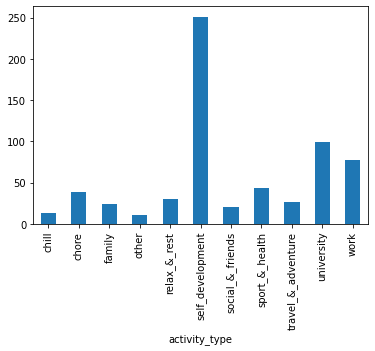

In [228]:
activities_df.groupby(by = ['activity_type']).activity_id.count().plot.bar()

In [80]:
posts_df = sql_to_df('posts')
posts_df.head(5)

,post_id,text,parsed_date,upload_date,edit_date,productivity_score,interest_score,stress_score,predicted_productivity_score,predicted_interest_score,predicted_stress_score
0,125,27.01.23\n❌ Statistics HM\n✅ Tinkoff HM (first...,2023-01-27,2023-01-27 08:45:32,2023-07-26 15:44:40,6.0,6.0,1.0,None,None,None
1,126,"28.01.23\nSlept for 6 hours, in the morning i ...",2023-01-28,2023-01-28 19:24:38,2023-07-26 15:44:31,4.0,4.0,3.0,None,None,None
2,127,29.01.23 \n\n✅ Statistics: seminar \n✅ TInkoff...,2023-01-29,2023-01-28 20:57:43,2023-07-26 15:44:17,5.0,5.0,2.0,None,None,None
3,128,30.01.23\n\n❌ Wiping with cold water\n✅ Sport:...,2023-01-30,2023-01-29 20:41:27,2023-07-26 15:43:52,7.0,7.0,1.0,None,None,None
4,129,31.01.23\n\n✅ Wiping with cold water\n✅ Sport:...,2023-01-31,2023-01-30 21:44:57,2023-07-26 15:43:42,7.0,7.0,1.0,None,None,None


# Activity classification: fine-tune DistilBERT/RoBERTa base

In [229]:
activity_types = ['self_development', 'university', 'work', 'relax_&_rest', 'chill', 'sport_&_health', 'family', 'social_&_friends', 'travel_&_adventure', 'chore', 'other']

In [230]:
encode_activity_type_dict

{'self_development': 0,
 'university': 1,
 'work': 2,
 'relax_&_rest': 3,
 'chill': 4,
 'sport_&_health': 5,
 'family': 6,
 'social_&_friends': 7,
 'travel_&_adventure': 8,
 'chore': 9,
 'other': 10}

In [231]:

df = activities_df[['activity_name','activity_type']]
def encode_type(x):
    return encode_activity_type_dict[x]

df['encoded_activity_type'] = df['activity_type'].apply(lambda x: encode_type(x))

<ipython-input-231-cf4deccc98b3>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['encoded_activity_type'] = df['activity_type'].apply(lambda x: encode_type(x))


In [232]:
df

,activity_name,activity_type,encoded_activity_type
0,Hiking with Ann,family,6
1,Working on my project,self_development,0
2,Gym,sport_&_health,5
3,Interesting history lecture,relax_&_rest,3
4,Awesome cycling with Anna and her brother,family,6
...,...,...,...
631,still recovering from lack of sleep,relax_&_rest,3
632,Slept for 6 hours in the morning i have visite...,other,10
633,Statistics HM,self_development,0
634,Tinkoff HM first two tasks,self_development,0


In [233]:
random_state = 1337


def set_seed(seed=random_state):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    tf.random.set_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    os.environ["PYTHONHASHSEED"] = str(seed)


In [234]:
import datetime
import time
import random
import os
import argparse

import pandas as pd
import numpy as np
import torch

from transformers import DistilBertModel, DistilBertTokenizer, get_linear_schedule_with_warmup
from torch.utils.data import Dataset, DataLoader
from torch import nn
from torch.cuda.amp import GradScaler, autocast

In [235]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-05
EPS =  1e-8
NUM_CLASSES = len(activity_types)

distilbert_path = '/media/tonyalpha/HDD/distilbert-base-uncased'

tokenizer = DistilBertTokenizer.from_pretrained(distilbert_path)

In [236]:
import torch

if torch.cuda.is_available():    
  
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")


No GPU available, using the CPU instead.


In [237]:
from torch.utils.data import Dataset, DataLoader

class dataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len
        
    def __getitem__(self, index):
        title = str(self.data.activity_type[index])
        inputs = self.tokenizer.encode_plus(
            title,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            truncation=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'input_ids': torch.tensor(ids, dtype=torch.long),
            'attention_mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.data.encoded_activity_type[index], dtype=torch.long)
        } 
    
    def __len__(self):
        return self.len

In [238]:
#let's define max sentence len 

max_len = 0

for sent in df.activity_name:
    input_ids = tokenizer.encode(sent, add_special_tokens=True)
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  36


In [239]:
MAX_LEN = 64

In [240]:
set_seed()

train_size = 0.8
train_dataset=df.sample(frac=train_size,random_state=random_state)
test_dataset=df.drop(train_dataset.index).reset_index(drop=True)
train_dataset = train_dataset.reset_index(drop=True)


print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = dataset(train_dataset, tokenizer, MAX_LEN)
testing_set = dataset(test_dataset, tokenizer, MAX_LEN)

FULL Dataset: (636, 3)
TRAIN Dataset: (509, 3)
TEST Dataset: (127, 3)


In [241]:
set_seed()

train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

train_loader = DataLoader(training_set, **train_params)
test_loader = DataLoader(testing_set, **test_params)

In [242]:
class DistillBERT_classifier(torch.nn.Module):
    def __init__(self):
        super(DistillBERT_classifier, self).__init__()
        self.l1 = DistilBertModel.from_pretrained(distilbert_path)
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, NUM_CLASSES)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [261]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    # if max(train_losses) / min(train_losses) > 10:
    #    axs[0].set_yscale('log')
    #
    # if max(train_metrics) / min(train_metrics) > 10:
    #    axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('metric')
    plt.show()


import torch
from tqdm.auto import tqdm


def train_and_validate(device, model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network to train
      - optimizer: optimizer chained to a model
      - criterion: loss function class
      - metric: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: DataLoader with train set
      - val_loader: DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
      - device: device to use for training and inference, e.g. 'cpu', 'cuda'
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''

    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []
    
    
    scaler = GradScaler()
    
    total_steps = len(train_loader) * num_epochs
    
    scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                                num_warmup_steps=0,
                                                num_training_steps=total_steps)
    

    for epoch in range(1, num_epochs + 1):
        
        model.train()
        running_loss, running_metric = 0, 0
        
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
        if verbose else train_loader

        for i, batch in enumerate(pbar, 1):
            
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            optimizer.zero_grad()
            
            with autocast():
                logits = model(ids, mask)               
                print(logits)
                loss = loss_function(logits, targets)
            
            
#             logits = logits.detach().cpu().numpy()
#             targets = targets.to('cpu').numpy()
            
            with torch.no_grad():
                big_val, big_idx = torch.max(logits.data, 1)
                
                metric_value = metric(big_idx, targets)
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()

                running_loss += loss.item() 
                running_metric += metric_value
                
                
            
                
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            scheduler.step()
           

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

        train_losses += [running_loss / len(train_loader)]
        train_metrics += [running_metric / len(train_loader)]
        
        
        model.eval()
        running_loss, running_metric = 0, 0
        
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
            if verbose else val_loader
        
        
        for i, batch in enumerate(pbar, 1):
            
            ids = batch['input_ids'].to(device)
            mask = batch['attention_mask'].to(device)
            targets = batch['targets'].to(device)

            with torch.no_grad():
                logits = model(ids, mask)
                loss = loss_function(logits.data, targets)
                
                logits = logits.detach().cpu().numpy()
                targets = targets.to('cpu').numpy()
                
                big_val, big_idx = torch.max(logits, 1)
                
                metric_value = metric(big_idx, targets)
                
                if type(metric_value) == torch.Tensor:
                    metric_value = metric_value.item()
                    
                running_loss += loss.item() 
                running_metric += metric_value

            if verbose and i % 100 == 0:
                pbar.set_postfix({'loss': loss.item(), 'MSE': metric_value})

                
        val_losses += [running_loss / len(val_loader)]
        val_metrics += [running_metric / len(val_loader)]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)

    if verbose:
        print(f'Validation metric: {val_metrics[-1]:.3f}')

    return train_metrics[-1], val_metrics[-1]



In [262]:
model = DistillBERT_classifier()
model.to(device)

loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr = LEARNING_RATE, eps = EPS)

Some weights of the model checkpoint at /media/tonyalpha/HDD/distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [263]:
# def accuracy(preds, labels):
#     pred_flat = np.argmax(preds, axis=1).flatten()
#     labels_flat = labels.flatten()
#     return np.sum(pred_flat == labels_flat) / len(labels_flat)


def accuracy(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
TRAIN_BATCH_SIZE = 16
VALID_BATCH_SIZE = 16
EPOCHS = 2
LEARNING_RATE = 2e-05
EPS =  1e-8
NUM_CLASSES = len(activity_types)

train_and_validate(device, model, optimizer, criterion = loss_function, metric = accuracy, 
                   train_loader = train_loader, val_loader = test_loader, num_epochs = EPOCHS, verbose=True)

Training 1/2:   0%|          | 0/32 [00:00<?, ?it/s]

tensor([[ 3.0060e-02,  2.2380e-01,  4.0729e-02, -3.3752e-02, -2.5865e-03,
          3.0194e-02,  2.4208e-01,  9.1844e-02,  1.3597e-01, -1.0335e-01,
         -3.9551e-02],
        [-6.3711e-02,  2.2819e-01, -1.4094e-01,  3.3548e-04, -1.0972e-01,
         -4.3385e-02,  8.6269e-02,  6.3497e-02,  3.5810e-02, -1.6480e-01,
          6.3041e-02],
        [ 2.7301e-02,  1.5747e-01, -1.3525e-01, -6.1496e-02, -1.0205e-01,
          7.6435e-02,  1.8177e-01,  6.1840e-02,  7.3966e-02, -2.6113e-01,
          2.1672e-02],
        [-1.0958e-01,  3.4734e-02, -1.5247e-01, -4.5077e-02,  4.0620e-02,
          3.6160e-02,  2.2490e-01, -1.1527e-02,  5.4076e-02, -1.8551e-01,
         -2.9914e-02],
        [-4.9113e-02,  2.4366e-01,  5.5673e-02, -2.1513e-02, -1.5648e-01,
          1.1012e-01,  1.8508e-01,  7.7540e-02,  1.7434e-02, -1.6668e-01,
         -3.5956e-02],
        [-9.0619e-02,  1.8842e-01, -1.7960e-04, -2.3264e-02, -7.8657e-02,
          5.3965e-02,  5.3099e-02,  1.7005e-01,  2.4123e-02, -1.4468e-0

In [ ]:
# Function to calcuate the accuracy of the model

def calcuate_accu(big_idx, targets):
    n_correct = (big_idx==targets).sum().item()
    return n_correct

In [ ]:
# Defining the training function on the 80% of the dataset for tuning the distilbert model

def train(epoch):
    tr_loss = 0
    n_correct = 0
    nb_tr_steps = 0
    nb_tr_examples = 0
    model.train()
    for _, data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.long)

        outputs = model(ids, mask)
        loss = loss_function(outputs, targets)
        tr_loss += loss.item()
        big_val, big_idx = torch.max(outputs.data, dim=1)
        n_correct += calcuate_accu(big_idx, targets)

        nb_tr_steps += 1
        nb_tr_examples+=targets.size(0)
        
        if _%5000==0:
            loss_step = tr_loss/nb_tr_steps
            accu_step = (n_correct*100)/nb_tr_examples 
            print(f"Training Loss per 5000 steps: {loss_step}")
            print(f"Training Accuracy per 5000 steps: {accu_step}")

        optimizer.zero_grad()
        loss.backward()
        # # When using GPU
        optimizer.step()

    print(f'The Total Accuracy for Epoch {epoch}: {(n_correct*100)/nb_tr_examples}')
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Training Loss Epoch: {epoch_loss}")
    print(f"Training Accuracy Epoch: {epoch_accu}")

    return 

In [ ]:
for epoch in range(EPOCHS):
    train(epoch)

In [ ]:
def valid(model, testing_loader):
    model.eval()
    n_correct = 0; n_wrong = 0; total = 0
    with torch.no_grad():
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.long)
            outputs = model(ids, mask).squeeze()
            loss = loss_function(outputs, targets)
            tr_loss += loss.item()
            big_val, big_idx = torch.max(outputs.data, dim=1)
            n_correct += calcuate_accu(big_idx, targets)

            nb_tr_steps += 1
            nb_tr_examples+=targets.size(0)
            
            if _%5000==0:
                loss_step = tr_loss/nb_tr_steps
                accu_step = (n_correct*100)/nb_tr_examples
                print(f"Validation Loss per 100 steps: {loss_step}")
                print(f"Validation Accuracy per 100 steps: {accu_step}")
    epoch_loss = tr_loss/nb_tr_steps
    epoch_accu = (n_correct*100)/nb_tr_examples
    print(f"Validation Loss Epoch: {epoch_loss}")
    print(f"Validation Accuracy Epoch: {epoch_accu}")
    
    return epoch_accu


In [ ]:
print('This is the validation section to print the accuracy and see how it performs')
print('Here we are leveraging on the dataloader crearted for the validation dataset, the approcah is using more of pytorch')

acc = valid(model, testing_loader)
print("Accuracy on test data = %0.2f%%" % acc)

In [ ]:
output_model_file = './models/pytorch_distilbert_news.bin'
output_vocab_file = './models/vocab_distilbert_news.bin'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved')
print('This tutorial is completed')

# Sentiment analysis 

In [2]:
# it's ok

In [31]:
from transformers import pipeline

bertweet_base_sentiment_analysis = pipeline("text-classification", model="/media/tonyalpha/HDD/bertweet-base-sentiment-analysis")

In [30]:
bertweet_base_sentiment_analysis('Sad day', top_k = 3)

[{'label': 'NEG', 'score': 0.8925472497940063},
 {'label': 'NEU', 'score': 0.0853690579533577},
 {'label': 'POS', 'score': 0.022083677351474762}]

# Sync with DB

# Etc 